In [1]:
import numpy as np
import glob
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.metrics import normalized_root_mse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as album

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/MyDrive/Machine_Learning/Crack_Detection') 
!pwd
%ls

/content/drive/MyDrive/Machine_Learning/Crack_Detection
 AEC_model.pth
 Autoencoders_Conv2d_Composites.ipynb
 Autoencoders_Conv2d.ipynb
 Crack_Detection_VGG16.ipynb
 data/
 Instance_Segmentation/
 jx_vit_base_p16_224-80ecf9dd.pth
 map_1.jpg
 map.jpg
 map_N.jpg
 Neg_00850.tif
 Pos_00045.tif
 Pos_00100.tif
 Pos_00200.tif
 Var_AEC/
 Varitional_Autoencoders_2D.ipynb
'VGG19_Crack_Detection&Localization.ipynb'
 ViTransformers.ipynb
 Yolo_v4/


In [4]:
# Normalization parameters for pre-trained PyTorch models
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])
class ImageDataset(Dataset):
    def __init__(self, files, lr_shape, augmentation=None):
        lr_height, lr_width = lr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
        self.files = files
        self.augmentation = augmentation
    
    def __getitem__(self, index):
        img = cv2.imread(self.files[index % len(self.files)], 0)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=img)
            img = sample['image']
            img = img/255.
        img_lr = self.lr_transform(img)
        return {"lr": img_lr}

    def __len__(self):
        return len(self.files)

# Defining Augmentations
def get_training_augmentation():
    train_transform = [    
        #album.RandomCrop(height=128, width=128, always_apply=False, p=0.25),
        album.Resize(height=128, width=128, always_apply=True, p=1, interpolation=cv2.INTER_AREA),
        album.OneOf(
            [album.HorizontalFlip(p=1),
             album.VerticalFlip(p=1),
             album.RandomRotate90(p=1),
            ], p=0.5),
    ]
    return album.Compose(train_transform)

def get_test_augmentation():
    train_transform = [    
        album.Resize(height=128, width=128, always_apply=True, p=1, interpolation=cv2.INTER_AREA)]
    return album.Compose(train_transform)

# Configure data loader
dataset_path = "data/Negative"
lr_shape=(128,128)
batch_size=64*3
train_paths, test_paths = train_test_split(sorted(glob.glob(dataset_path + "/*.tif*")), test_size=0.3)
train_loader = DataLoader(ImageDataset(train_paths, lr_shape=lr_shape, augmentation=get_training_augmentation()), batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)#augmentation=get_training_augmentation()
test_loader  = DataLoader(ImageDataset(test_paths, lr_shape=lr_shape, augmentation=get_test_augmentation()), batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

# Configure valid data loader
dataset_path = "data/Positive"
valid_loader = DataLoader(ImageDataset(glob.glob(dataset_path + "/*.tif*"), lr_shape=lr_shape, augmentation=get_test_augmentation()), batch_size=batch_size, num_workers=2, shuffle=True, drop_last=True)

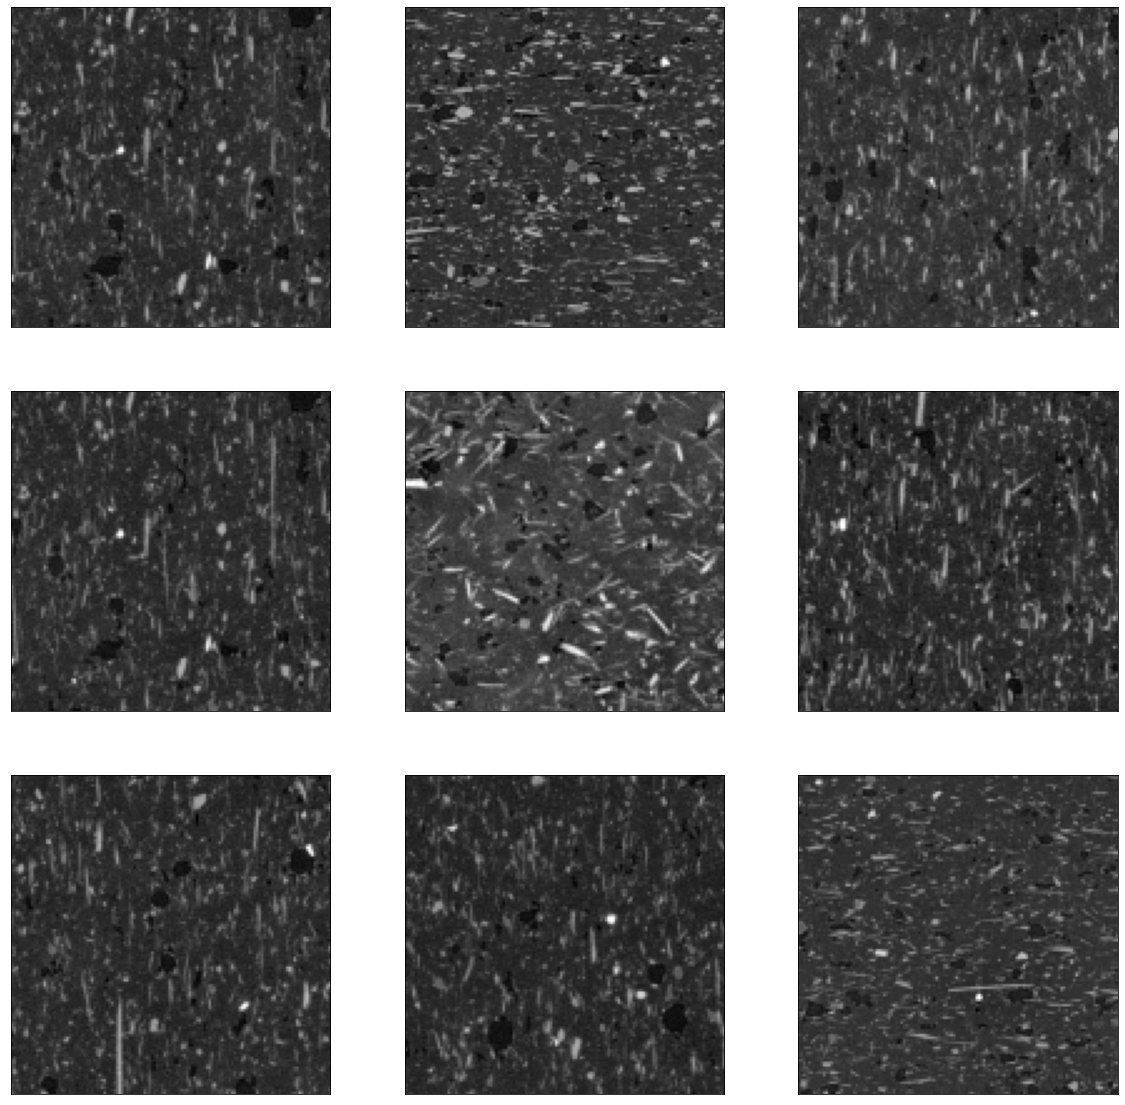

In [5]:
def imshow(img):
    plt.imshow(np.squeeze(np.transpose(img, (1, 2, 0))), cmap = "gray", vmin= np.min(img), vmax=np.max(img)) 

#Obtain one batch of training images
dataiter = iter(train_loader)
imgs = dataiter.next()
images = imgs["lr"]
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(20, 20))
# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [6]:
#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.main = nn.Sequential(
            # input going into a convolution
            nn.Conv2d(1, 64*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            #
            nn.Conv2d(64*2, 64*2, 3, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            #
            nn.Conv2d(64*2, 64*3, 3, padding=1, bias=False),
            nn.BatchNorm2d(64*3),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            #
            nn.Conv2d(64*3, 64*4, 3, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            #
            nn.Conv2d(64*4, 64*5, 3, padding=1, bias=False),
            nn.BatchNorm2d(64*5),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),  
            #
            nn.Conv2d(64*5, 64*6, 3, padding=1, bias=False),
            nn.BatchNorm2d(64*6),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2), 
            #
            nn.Conv2d(64*6, 100, 3, padding=1, bias=False),
            nn.BatchNorm2d(100),
            nn.ReLU(True),
            # Pooling
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),    
            # state size. 64*6 
            nn.ConvTranspose2d(100, 64*6, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64*6),
            nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64*5 
            nn.ConvTranspose2d(64*6, 64*5, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64*5),
            nn.Dropout(0.2),
            nn.ReLU(True),                                                                  
            # state size. 64*4 
            nn.ConvTranspose2d(64*5, 64*4, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64*4),
            nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64*3 
            nn.ConvTranspose2d(64*4, 64*3, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64*3),
            nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64*2 
            nn.ConvTranspose2d(64*3, 64*2, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. 64*1 
            nn.ConvTranspose2d(64*2, 64*2, 4, stride =2, padding=1, bias=False),
            nn.BatchNorm2d(64*2),
            nn.Dropout(0.2),
            nn.ReLU(True),
            # state size. outchanels = 3           
            nn.ConvTranspose2d(64*2, 1, 4, stride =2, padding=1, bias=False),
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

#Instantiate the model
model = ConvAutoencoder()

In [7]:
#Loss function
criterion = nn.MSELoss()#nn.BCELoss()#torch.nn.BCEWithLogitsLoss()#

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [8]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)
summary(model,(1,128,128))

# Load pretrained models
load_pretrained_models = True
model_path = "AEC_model.pth"
if load_pretrained_models:
    model.load_state_dict(torch.load(model_path,map_location=device))#map_location=torch.device('cpu')

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           1,152
       BatchNorm2d-2        [-1, 128, 128, 128]             256
              ReLU-3        [-1, 128, 128, 128]               0
         MaxPool2d-4          [-1, 128, 64, 64]               0
           Dropout-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
              ReLU-8          [-1, 128, 64, 64]               0
         MaxPool2d-9          [-1, 128, 32, 32]               0
          Dropout-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 192, 32, 32]         221,184
      BatchNorm2d-12          [-1, 192, 32, 32]             384
             ReLU-13          [-1, 192, 32, 32]               0
        MaxPool2d-14          [-

In [9]:
#Epochs
n_epochs = 0

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for i, imgs in enumerate(train_loader):
        images = imgs["lr"].type(Tensor)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)

    if (epoch)%10 == 0:
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

    # Save model checkpoints
    if (epoch)%100 == 0:
        torch.save(model.state_dict(), "AEC_model.pth")
        print('save model!')

Original Images


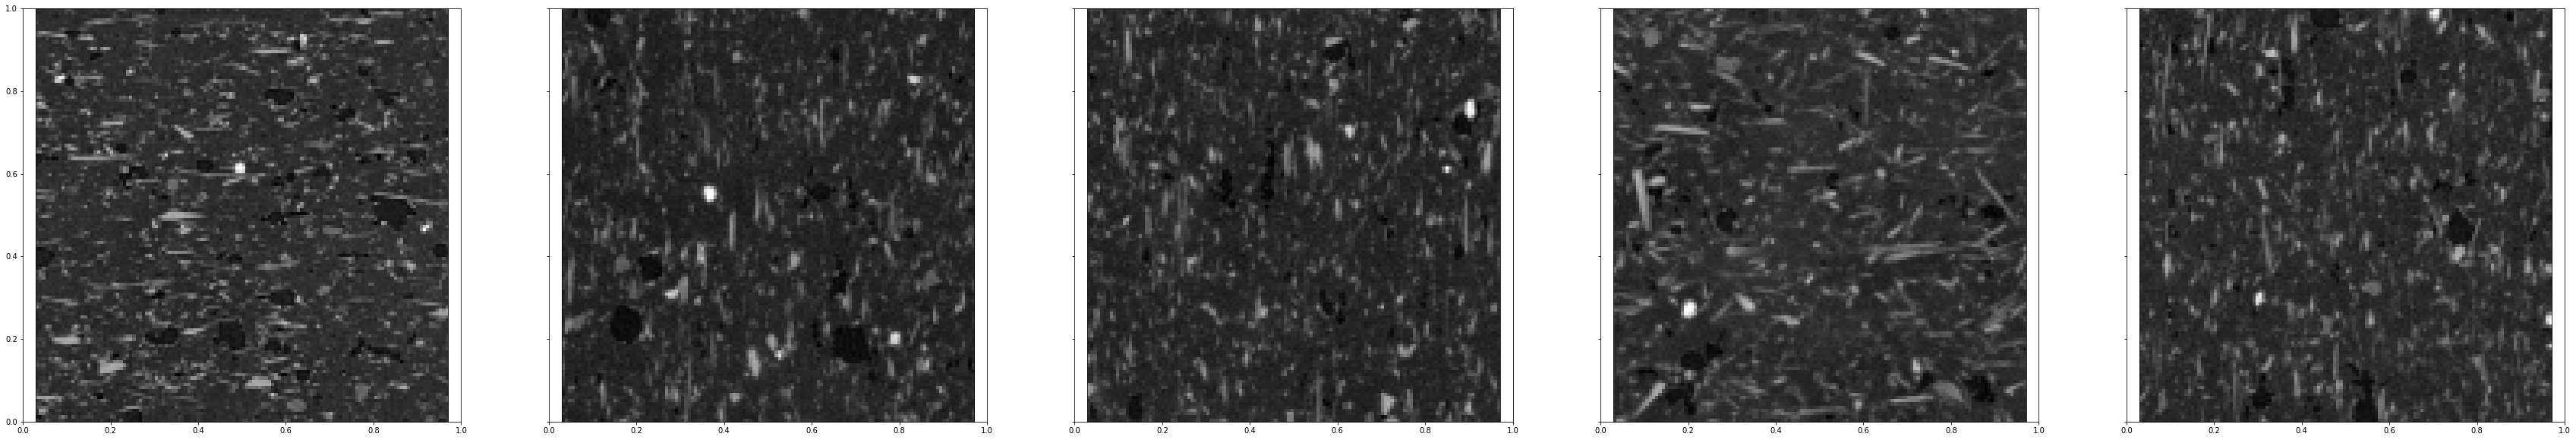

Reconstructed Images


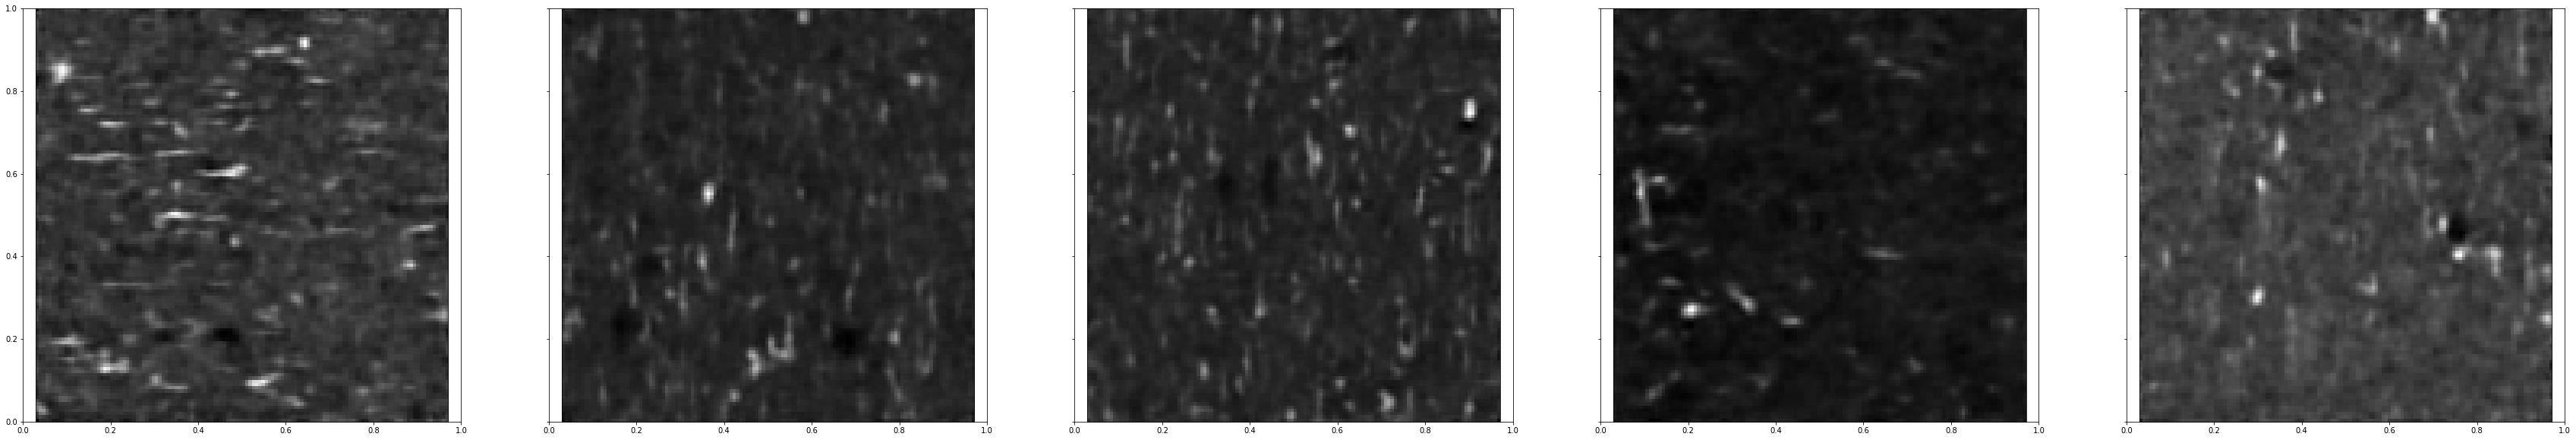

192 0.12533527023362914 0.2807950141948346


In [10]:
#Batch of train images
dataiter = iter(train_loader)
imgs = dataiter.next()
images = imgs["lr"]

#Sample outputs
output = model(images.type(Tensor))

output = output.cpu()
images = images.numpy()
output = output.view(batch_size, 1, 128, 128)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

#Loss
Loss =[]
for idx in np.arange(batch_size):
  Loss.append(normalized_root_mse(images[idx],output[idx]))
print(len(Loss), min(Loss), max(Loss))

Original Images


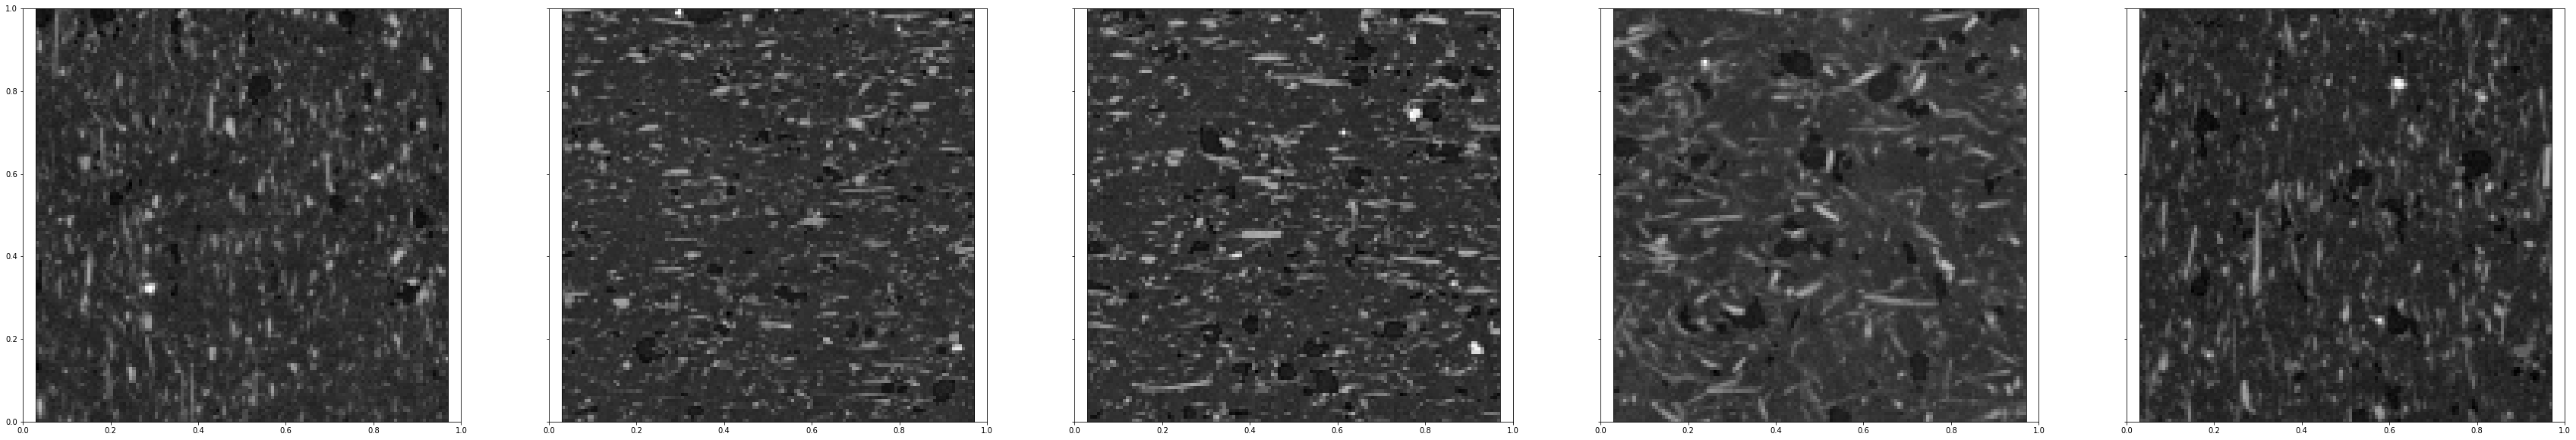

Reconstructed Images


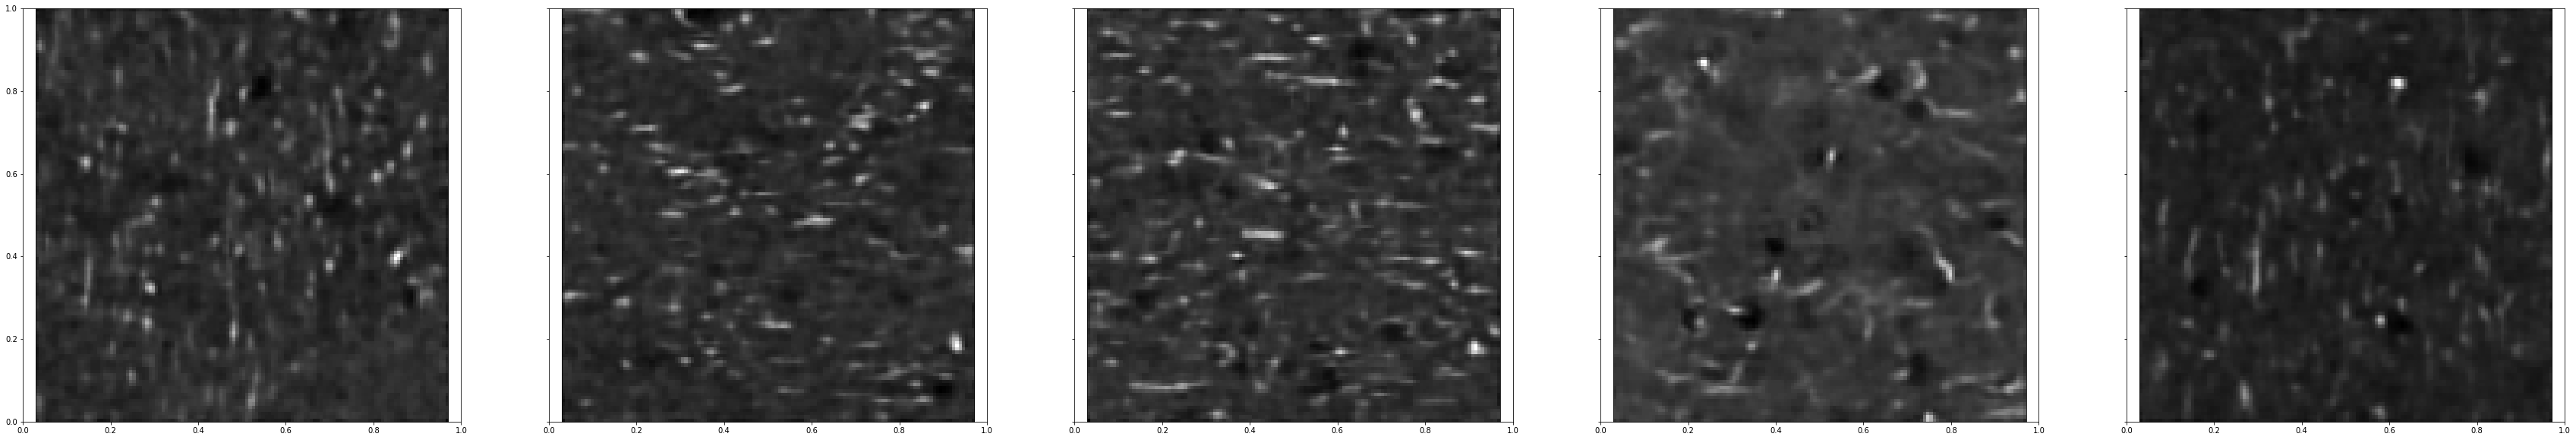

64 0.1255611905012859 0.2199797695455574


In [11]:
#Batch of test images
dataiter = iter(test_loader)
imgs = dataiter.next()
images = imgs["lr"]

#Sample outputs
output = model(images.type(Tensor))

output = output.cpu()
images = images.numpy()
output = output.view(batch_size, 1, 128, 128)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

#Loss
Loss_N =[]
for idx in np.arange(64):
  Loss_N.append(normalized_root_mse(images[idx],output[idx]))
print(len(Loss_N),  min(Loss_N), max(Loss_N))

Original Images


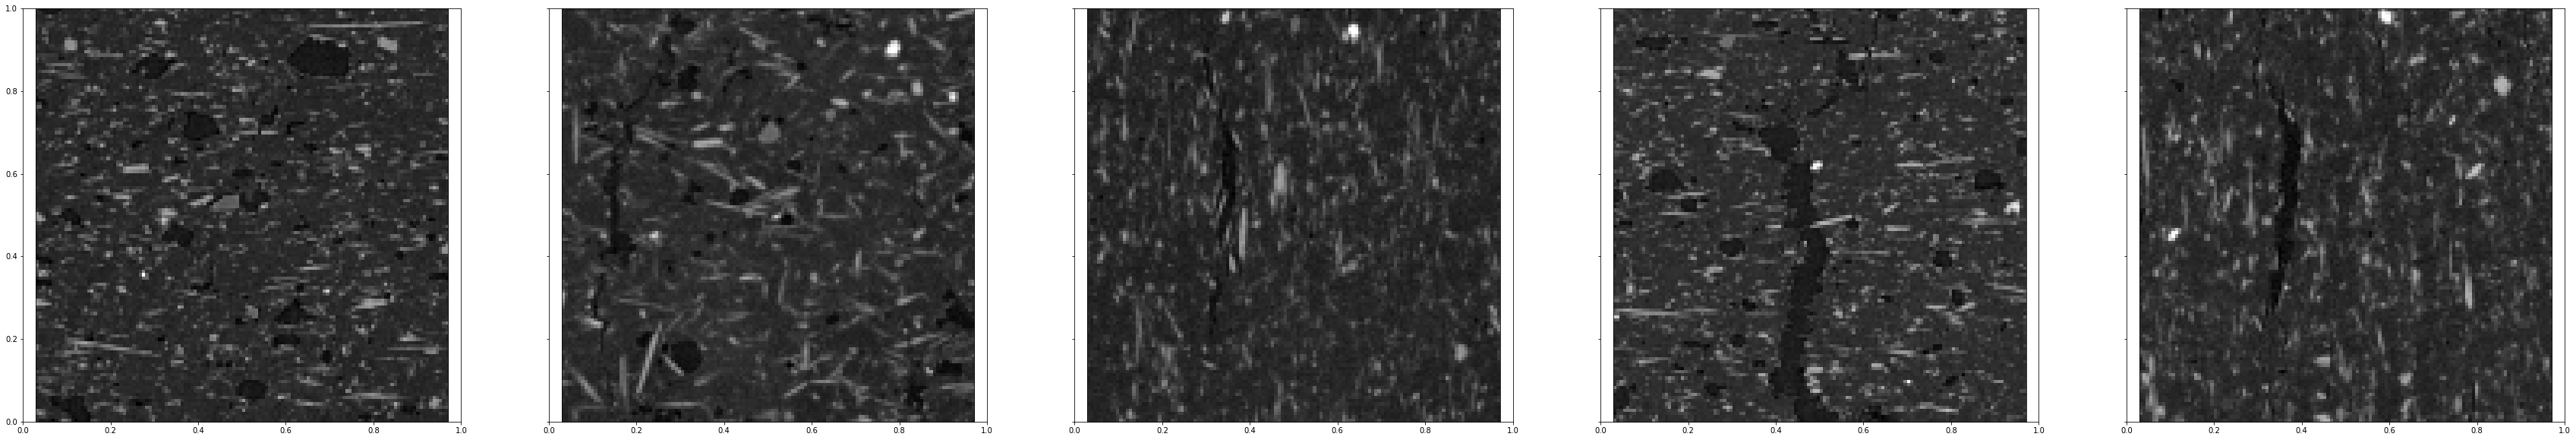

Reconstructed Images


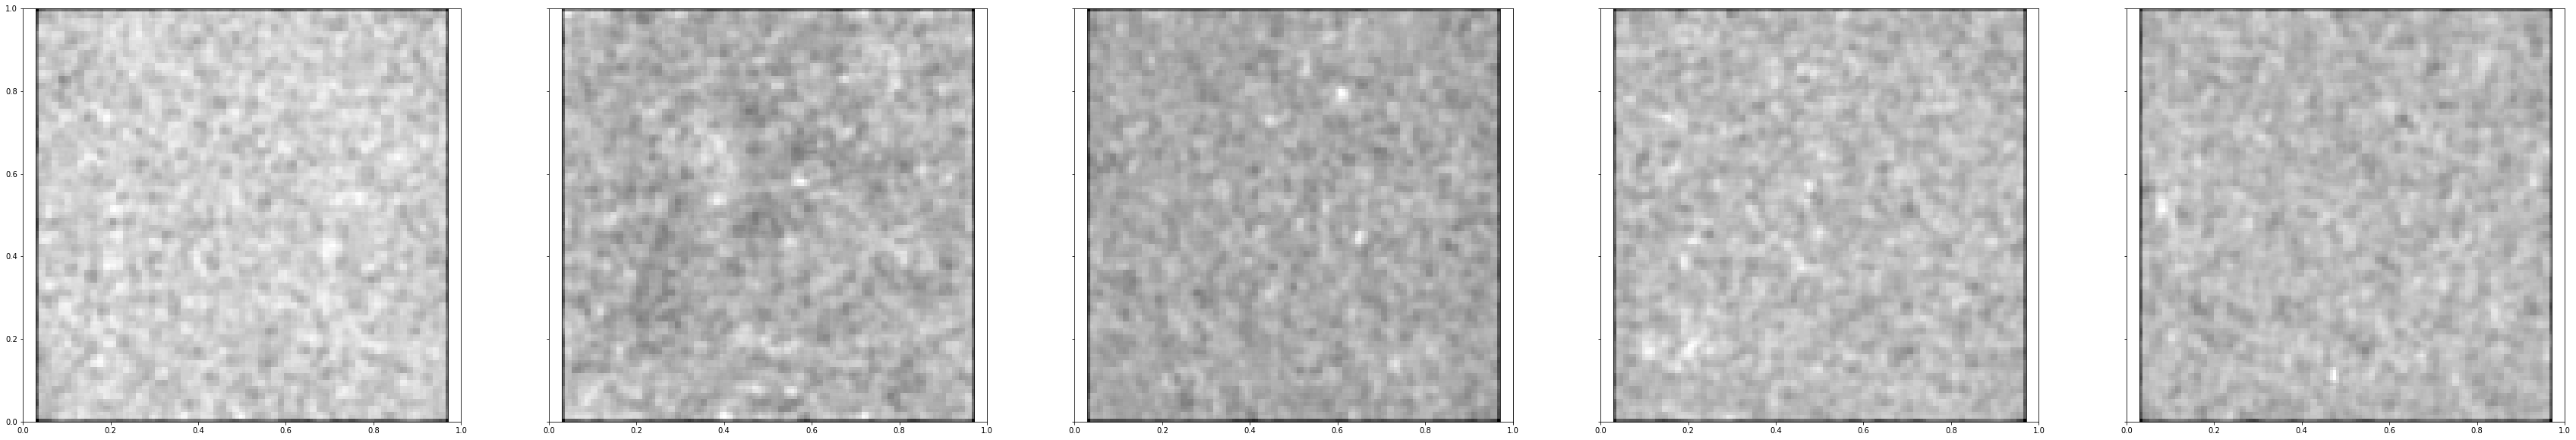

64 0.16775061450972928 0.3453137535797476


In [12]:
#Batch of valid images
dataiter = iter(valid_loader)
imgs = dataiter.next()
images = imgs["lr"]

#Sample outputs
output = model(images.type(Tensor))

output = output.cpu()
images = images.numpy()
output = output.view(batch_size, 1, 128, 128)
output = output.detach().numpy()

#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(60,10))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(output[idx])
plt.show() 

#Loss
Loss_P =[]
for idx in np.arange(64):
  Loss_P.append(normalized_root_mse(images[idx],output[idx]))
print(len(Loss_P),  min(Loss_P), max(Loss_P))

In [13]:
np.sum(np.asarray(Loss_N) >0.2)

8

In [14]:
np.sum(np.asarray(Loss_P) <0.2)

11